In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

In [2]:

# Load raw audio files for speech synthesis
def load_train_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("./dataset/triggers"):
        if filename.endswith("wav"):
            padding = AudioSegment.silent(duration=2000)
            segment = AudioSegment.from_wav("./dataset/triggers/"+filename)[:2000]
            activate = padding.overlay(segment)
            activates.append(activate[:2000])
            continue
    for filename in os.listdir("./dataset/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("./dataset/backgrounds/"+filename)
            backgrounds.append(background[:10000])
            continue
    for neg_dirs in os.listdir("./dataset/negatives"):
        for filename in os.listdir("./dataset/negatives/"+neg_dirs):
            if filename.endswith("wav"):
                padding = AudioSegment.silent(duration=2000)
                segment = AudioSegment.from_wav("./dataset/negatives/"+neg_dirs+"/"+filename)[:2000]
                negative = padding.overlay(segment)
                negatives.append(negative)
                continue
                
    return activates, negatives, backgrounds

# Load raw audio files for speech synthesis
def load_test_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("./dataset/test/triggers"):
        if filename.endswith("wav"):
            padding = AudioSegment.silent(duration=2000)
            segment = AudioSegment.from_wav("./dataset/test/triggers/"+filename)[:2000]
            activate = padding.overlay(segment)
            activates.append(activate[:2000])
            continue
    for filename in os.listdir("./dataset/test/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("./dataset/test/backgrounds/"+filename)
            backgrounds.append(background[:10000])
            continue
    for neg_dirs in os.listdir("./dataset/test/negatives"):
        for filename in os.listdir("./dataset/test/negatives/"+neg_dirs):
            if filename.endswith("wav"):
                padding = AudioSegment.silent(duration=2000)
                segment = AudioSegment.from_wav("./dataset/test/negatives/"+neg_dirs+"/"+filename)[:2000]
                negative = padding.overlay(segment)
                negatives.append(negative)
                continue
                
    return activates, negatives, backgrounds

In [4]:
IPython.display.Audio("./dataset/triggers/18-2.wav")

/home/msain/anaconda3/envs/tensorflow_cpuenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


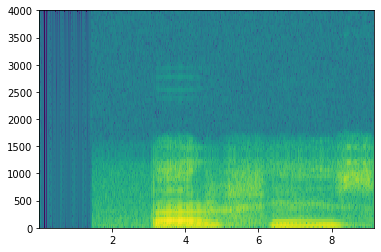

In [5]:
x = graph_spectrogram("./dataset/triggers/18-2.wav")

In [6]:
_, data = wavfile.read("./dataset/triggers/18-2.wav")
print("Time steps in audio recording before spectrogram", data.shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (73464,)
Time steps in input after spectrogram (101, 916)


In [7]:
Tx = 5998 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [8]:
Ty = 1496 # The number of time steps in the output of our model

In [9]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_train_audio()
activates_test, negatives_test, backgrounds_test = load_test_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 

background len: 10000
activate[0] len: 2000
activate[1] len: 2000


In [10]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [11]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Step 1: Initialize overlap as a "False" flag.
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [12]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [13]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. 
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. 
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments 
    previous_segments.append(segment_time)
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [14]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)


Segment Time:  (1725, 3724)


In [15]:
IPython.display.Audio("insert_test.wav")

In [16]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < Ty:
            y[0, i] = 1.0
    
    return y

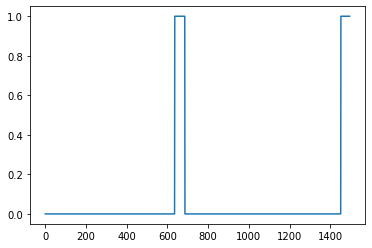

In [17]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])

In [18]:
def create_training_example(background, activates, negatives, counter, is_test = False ):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    

    
    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros 
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list 
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 3) 
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
            
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 2)

    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("./training_samples/train_" + str(counter) + ('_test' if is_test else '_train') + ".wav", format="wav")
    print("File (train_" + str(counter) + ".wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("./training_samples/train_" + str(counter) + ('_test' if is_test else '_train') + ".wav")
    
    return x, y

In [19]:
# Set the random seed
np.random.seed(1)

File (train_1.wav) was saved in your directory.


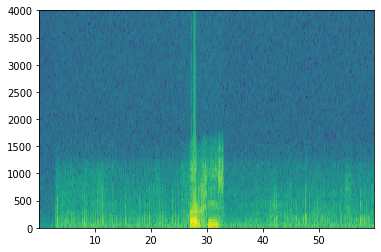

In [20]:
x, y = create_training_example(backgrounds[0], activates, negatives, 1)

Now you can listen to the training example you created and compare it to the spectrogram generated above.

In [21]:
IPython.display.Audio("./training_samples/train_1_train.wav")

Finally, you can plot the associated labels for the generated training example.

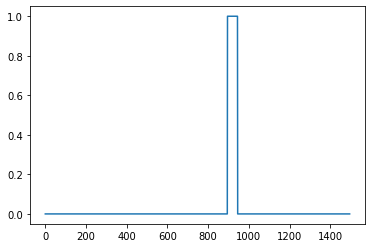

In [22]:
plt.plot(y[0])

In [23]:
def generate_data(batch_size):
    while True:
        X = []
        Y = []
        for background in backgrounds:
            _x, _y = create_training_example(background, activates, negatives, 100)
            X.append(_x.T)
            Y.append(_y.T)

            yield np.array(X), np.array(Y)


## 1.5 - Development set

To test our model, we recorded a development set of 25 examples. While our training data is synthesized, we want to create a development set using the same distribution as the real inputs. Thus, we recorded 25 10-second audio clips of people saying "activate" and other random words, and labeled them by hand. We should create the dev set to be as similar as possible to the test set distribution; that's why our dev set uses real rather than synthesized audio. 


File (train_1.wav) was saved in your directory.
(101, 5998)
File (train_2.wav) was saved in your directory.
(101, 5998)
File (train_3.wav) was saved in your directory.
(101, 5998)
File (train_4.wav) was saved in your directory.
(101, 5998)
File (train_5.wav) was saved in your directory.
(101, 5998)
File (train_6.wav) was saved in your directory.
(101, 5998)
File (train_7.wav) was saved in your directory.
(101, 5998)
File (train_8.wav) was saved in your directory.
(101, 5998)
File (train_9.wav) was saved in your directory.
(101, 5998)
File (train_10.wav) was saved in your directory.
(101, 5998)
File (train_11.wav) was saved in your directory.
(101, 5998)
File (train_12.wav) was saved in your directory.
(101, 5998)
File (train_13.wav) was saved in your directory.
(101, 5998)
File (train_14.wav) was saved in your directory.
(101, 5998)
File (train_15.wav) was saved in your directory.
(101, 5998)
File (train_16.wav) was saved in your directory.
(101, 5998)
File (train_17.wav) was saved in 

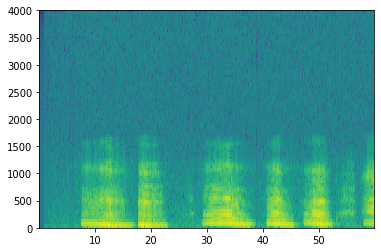

In [24]:
X_dev = []
Y_dev = []
counter = 1

for background in backgrounds_test:
    for j in range(20):
        _x, _y = create_training_example(background, activates_test, negatives_test, counter, True)
        print(np.array(_x).shape)
        X_dev.append(_x.T)
        Y_dev.append(_y.T)
        counter += 1
X_dev = np.array(X_dev)
Y_dev = np.array(Y_dev)

In [25]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [26]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
      
    # Step 1: CONV layer
    X = Conv1D(196, 15, strides=4)(X_input)                    # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation('relu')(X)                                  # ReLu activation
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    # Step 2: First GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 3: Second GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [27]:
model = model(input_shape = (Tx, n_freq))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5998, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1496, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1496, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1496, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1496, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1496, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1496, 128)         0         
__________

## 2.2 - Fit the model

In [29]:
model = load_model('./model_21.h5')

Instructions for updating:
Use tf.cast instead.


In [30]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

Epoch 1/1
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.


/home/msain/anaconda3/envs/tensorflow_cpuenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
File (train_100.wav) was saved in your directory.
50/50 [==============================] - 158s 3s/step - loss: 0.8692 - acc: 0.7305


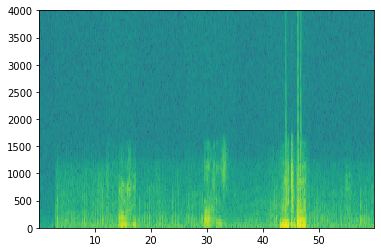

In [31]:
model.fit_generator(generate_data(5), steps_per_epoch = 50, epochs=1)
model.save('./model.h5')

## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [32]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

20/20 [==============================] - 2s 87ms/step
Dev set accuracy =  0.9743649959564209


# 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [33]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [34]:
chime_file = "./beep.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

## 3.3 - Test on dev examples

In [35]:
IPython.display.Audio("./dataset/test/triggers/38-1.ogg.wav")

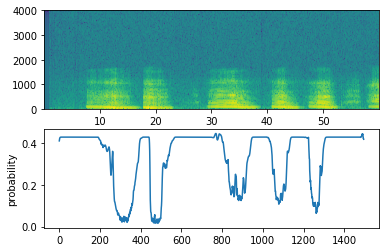

In [37]:
filename  = "./training_samples/train_2_test.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
filename  = "./training_samples/train_3_test.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
filename  = "./training_samples/train_6_test.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
filename  = "./training_samples/train_7_test.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
filename  = "./training_samples/train_15_test.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
filename  = "./training_samples/train_101_train.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

# 4 - Try your own example

In [38]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

Once you've uploaded your audio file to Coursera, put the path to your file in the variable below.

In [ ]:
your_filename = "audio_examples/my_audio.wav"

In [ ]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

Finally, use the model to predict when you say activate in the 10 second audio clip, and trigger a chime. If beeps are not being added appropriately, try to adjust the chime_threshold.

In [ ]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")